In [1]:
# ---- Core imports ----
import numpy as np
import cv2
from pathlib import Path

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# ---- Robust skimage imports (works across versions) ----
from skimage.feature import hog, local_binary_pattern

# GLCM – version-safe import
try:
    from skimage.feature import graycomatrix, graycoprops
except ImportError:
    # some versions move them to .texture
    from skimage.feature.texture import graycomatrix, graycoprops

from skimage.morphology import skeletonize
from skimage.measure import label, regionprops

# ---- Classical ML ----
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from joblib import Parallel, delayed
import pandas as pd

# XGBoost – optional
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except ImportError:
    HAS_XGB = False
    print("xgboost not found – XGBClassifier section will be skipped.")


In [2]:
# ---- Dataset paths ----
CLASSES = [
    "background",
    "missing_hole",
    "mouse_bite",
    "open_circuit",
    "short",
    "spur",
    "spurious_copper",
]

# If notebook is inside <repo>/notebooks, go up one; else use CWD as repo root
REPO_ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
PATCH_ROOT = REPO_ROOT / "data" / "patches_sw"

print("Repo root :", REPO_ROOT)
print("PATCH_ROOT:", PATCH_ROOT)
print("Exists?   :", PATCH_ROOT.exists())

# Quick count per split / class
for split in ["train", "valid", "test"]:
    print(f"\nSPLIT: {split}")
    split_dir = PATCH_ROOT / split
    for cls in CLASSES:
        cls_dir = split_dir / cls
        cnt = len(list(cls_dir.glob("*.jpg")))
        print(f"{cls:15s} -> {cnt}")


Repo root : C:\Users\amrik\Data Science\Personal-PCB-Project
PATCH_ROOT: C:\Users\amrik\Data Science\Personal-PCB-Project\data\patches_sw
Exists?   : True

SPLIT: train
background      -> 24354
missing_hole    -> 3988
mouse_bite      -> 4120
open_circuit    -> 3771
short           -> 4032
spur            -> 3971
spurious_copper -> 3382

SPLIT: valid
background      -> 11306
missing_hole    -> 1871
mouse_bite      -> 2140
open_circuit    -> 1846
short           -> 2169
spur            -> 1863
spurious_copper -> 1753

SPLIT: test
background      -> 3866
missing_hole    -> 715
mouse_bite      -> 460
open_circuit    -> 674
short           -> 840
spur            -> 610
spurious_copper -> 622


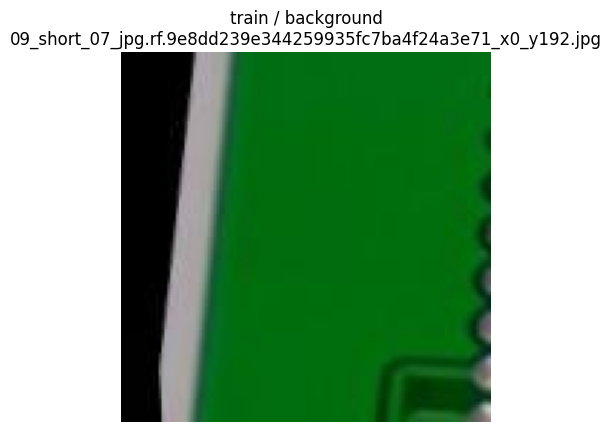

In [3]:
def show_random_patch(split="train"):
    """Show one random patch and its class, for sanity."""
    rng = np.random.default_rng(42)
    split_dir = PATCH_ROOT / split
    cls = rng.choice(CLASSES)
    cls_dir = split_dir / cls
    paths = sorted(cls_dir.glob("*.jpg"))
    if not paths:
        print("No patches found for", split, cls)
        return
    p = rng.choice(paths)
    img_bgr = cv2.imread(str(p))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(f"{split} / {cls}\n{p.name}")
    plt.show()

show_random_patch("train")


In [4]:
def split_into_grid(img, n_rows=2, n_cols=2):
    """Split a 2D image into an n_rows x n_cols grid of patches."""
    h, w = img.shape
    r_step, c_step = h // n_rows, w // n_cols
    patches = []
    for r in range(n_rows):
        for c in range(n_cols):
            patch = img[r*r_step:(r+1)*r_step, c*c_step:(c+1)*c_step]
            patches.append(patch)
    return patches


In [5]:
def zoned_hog(img_gray, n_rows=2, n_cols=2,
              orientations=8, pixels_per_cell=(8, 8),
              cells_per_block=(1, 1)):
    """HOG over a 2x2 grid; HOG per zone concatenated."""
    patches = split_into_grid(img_gray, n_rows=n_rows, n_cols=n_cols)
    feats = []
    for p in patches:
        h = hog(
            p,
            orientations=orientations,
            pixels_per_cell=pixels_per_cell,
            cells_per_block=cells_per_block,
            block_norm="L2-Hys",
            feature_vector=True,
        )
        feats.append(h.astype(np.float32))
    return np.concatenate(feats)


In [6]:
LBP_P = 8
LBP_R = 1

def lbp_hist(img_gray):
    lbp = local_binary_pattern(img_gray, P=LBP_P, R=LBP_R, method="uniform")
    # bins: 0..P + 1 (uniform patterns plus one)
    hist, _ = np.histogram(
        lbp,
        bins=np.arange(0, LBP_P + 3),
        range=(0, LBP_P + 2),
        density=True,
    )
    return hist.astype(np.float32)


In [7]:
def glcm_features(img_gray):
    """GLCM over 4 angles, 1 distance, 3 props -> 12 dims."""
    img_q = (img_gray / 4).astype(np.uint8)  # 0..63
    distances = [1]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(
        img_q,
        distances=distances,
        angles=angles,
        levels=64,
        symmetric=True,
        normed=True,
    )
    props = ["contrast", "homogeneity", "ASM"]
    feats = []
    for prop in props:
        vals = graycoprops(glcm, prop)  # shape (len(distances), len(angles))
        feats.append(vals.ravel())
    return np.concatenate(feats).astype(np.float32)  # 3 * 4 = 12


In [8]:
def zoned_lbp_glcm(img_gray, n_rows=2, n_cols=2):
    patches = split_into_grid(img_gray, n_rows=n_rows, n_cols=n_cols)
    lbp_all, glcm_all = [], []
    for p in patches:
        lbp_all.append(lbp_hist(p))
        glcm_all.append(glcm_features(p))
    return np.concatenate(lbp_all), np.concatenate(glcm_all)


In [9]:
def edge_stats(img_gray):
    edges = cv2.Canny(img_gray, 50, 150)
    edge_ratio = edges.mean().astype(np.float32)

    sobelx = cv2.Sobel(img_gray, cv2.CV_32F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img_gray, cv2.CV_32F, 0, 1, ksize=3)
    angles = np.arctan2(sobely, sobelx)
    if np.any(edges):
        orient_std = np.std(angles[edges > 0]).astype(np.float32)
    else:
        orient_std = np.float32(0.0)
    return np.array([edge_ratio, orient_std], dtype=np.float32)


In [10]:
def color_stats(img_rgb):
    # img_rgb: HxWx3, uint8
    mean = img_rgb.mean(axis=(0, 1)) / 255.0
    std = img_rgb.std(axis=(0, 1)) / 255.0
    return np.concatenate([mean, std]).astype(np.float32)  # 6 dims


In [11]:
def pad_shape_features(img_gray):
    """
    Rough copper / pad shape stats using simple threshold + largest component.
    Useful for holes, shorts, opens.
    """
    # Otsu threshold
    _, th = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Invert if mostly white
    if th.mean() > 127:
        th = 255 - th

    lbl = label(th > 0)
    props = regionprops(lbl)
    if not props:
        return np.zeros(4, dtype=np.float32)

    # largest region
    r = max(props, key=lambda p: p.area)

    area = float(r.area)
    perimeter = float(r.perimeter) if r.perimeter is not None else 0.0
    ecc = float(r.eccentricity)
    solidity = float(r.solidity)

    return np.array([area, perimeter, ecc, solidity], dtype=np.float32)


In [12]:
def fast_features(img_gray):
    fast = cv2.FastFeatureDetector_create(threshold=20, nonmaxSuppression=True)
    kpts = fast.detect(img_gray, None)
    n = len(kpts)
    if n > 0:
        responses = np.array([kp.response for kp in kpts], dtype=np.float32)
        resp_mean = float(responses.mean())
    else:
        resp_mean = 0.0
    return np.array([n, resp_mean], dtype=np.float32)


In [13]:
def orb_features(img_gray):
    orb = cv2.ORB_create(nfeatures=256, fastThreshold=20)
    kpts = orb.detect(img_gray, None)
    n = len(kpts)
    if n > 0:
        sizes = np.array([kp.size for kp in kpts], dtype=np.float32)
        size_mean = float(sizes.mean())
    else:
        size_mean = 0.0
    return np.array([n, size_mean], dtype=np.float32)


In [14]:
def fft_features(img_gray):
    f = np.fft.fft2(img_gray.astype(np.float32))
    fshift = np.fft.fftshift(f)
    mag = np.abs(fshift)

    h, w = mag.shape
    cy, cx = h // 2, w // 2
    r = min(h, w) // 8  # small center window
    center = mag[cy-r:cy+r, cx-r:cx+r].sum()
    total = mag.sum() + 1e-6

    low_ratio = float(center / total)
    high_ratio = float((total - center) / total)
    return np.array([low_ratio, high_ratio], dtype=np.float32)


In [15]:
def contrast_features(img_gray):
    std = float(img_gray.std() / 255.0)
    rng = float((img_gray.max() - img_gray.min()) / 255.0)
    return np.array([std, rng], dtype=np.float32)


In [16]:
def extract_features_multi(img_rgb):
    """
    Multi-scale HOG pyramid + zoned LBP/GLCM + remaining scalar features.
    img_rgb is assumed 64x64 (we will resize to that size first).
    """
    # Normalize to 64x64 to keep feature dims consistent
    img_rgb = cv2.resize(img_rgb, (64, 64), interpolation=cv2.INTER_AREA)
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    # ---- HOG pyramid (64, 32, 16) with zoned HOG ----
    hog_feats = []
    for size in [64, 32, 16]:
        img_resized = cv2.resize(img_gray, (size, size), interpolation=cv2.INTER_AREA)
        hog_feats.append(zoned_hog(img_resized))  # length depends on size
    hog_feats = np.concatenate(hog_feats).astype(np.float32)

    # ---- Non-HOG features on base scale (64x64) ----
    lbp_z, glcm_z = zoned_lbp_glcm(img_gray)           # 2x2 grid
    edge_feat = edge_stats(img_gray)                   # 2
    color_feat = color_stats(img_rgb)                  # 6
    pad_shape = pad_shape_features(img_gray)           # 4
    fast_feat = fast_features(img_gray)                # 2
    orb_feat = orb_features(img_gray)                  # 2
    fft_feat = fft_features(img_gray)                  # 2
    contrast_feat = contrast_features(img_gray)        # 2

    other_feats = np.concatenate([
        lbp_z, glcm_z, edge_feat, color_feat,
        pad_shape, fast_feat, orb_feat, fft_feat, contrast_feat
    ]).astype(np.float32)

    return hog_feats, other_feats


In [17]:
# Pick one random train patch to probe feature sizes
probe_split_dir = PATCH_ROOT / "train"
probe_cls = CLASSES[0]
probe_path = next((probe_split_dir / probe_cls).glob("*.jpg"))

img_bgr = cv2.imread(str(probe_path))
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

hog_probe, other_probe = extract_features_multi(img_rgb)
HOG_RAW_LEN = len(hog_probe)
OTHER_LEN = len(other_probe)

print("HOG_RAW_LEN :", HOG_RAW_LEN)
print("OTHER_LEN   :", OTHER_LEN)
print("TOTAL (raw) :", HOG_RAW_LEN + OTHER_LEN)

# Now decompose the "other" block into sub-block lengths
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
lbp_z, glcm_z = zoned_lbp_glcm(img_gray)
EDGE_LEN = len(edge_stats(img_gray))
COLOR_LEN = len(color_stats(img_rgb))
PAD_LEN = len(pad_shape_features(img_gray))
FAST_LEN = len(fast_features(img_gray))
ORB_LEN = len(orb_features(img_gray))
FFT_LEN = len(fft_features(img_gray))
CONTRAST_LEN = len(contrast_features(img_gray))

LBP_LEN = len(lbp_z)
GLCM_LEN = len(glcm_z)

print("\nOther block lengths:")
print("LBP     :", LBP_LEN)
print("GLCM    :", GLCM_LEN)
print("EDGE    :", EDGE_LEN)
print("COLOR   :", COLOR_LEN)
print("PAD     :", PAD_LEN)
print("FAST    :", FAST_LEN)
print("ORB     :", ORB_LEN)
print("FFT     :", FFT_LEN)
print("CONTRAST:", CONTRAST_LEN)
assert OTHER_LEN == (LBP_LEN + GLCM_LEN + EDGE_LEN + COLOR_LEN +
                     PAD_LEN + FAST_LEN + ORB_LEN + FFT_LEN + CONTRAST_LEN)


HOG_RAW_LEN : 672
OTHER_LEN   : 108
TOTAL (raw) : 780

Other block lengths:
LBP     : 40
GLCM    : 48
EDGE    : 2
COLOR   : 6
PAD     : 4
FAST    : 2
ORB     : 2
FFT     : 2
CONTRAST: 2


In [18]:
def load_patch(path):
    img_bgr = cv2.imread(str(path))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    hog_f, other_f = extract_features_multi(img_rgb)
    feat = np.concatenate([hog_f, other_f])
    label_name = path.parent.name
    label_idx = CLASSES.index(label_name)
    return feat, label_idx

def build_feature_matrix(split, n_jobs=4):
    split_dir = PATCH_ROOT / split
    all_feat = []
    all_label = []

    for cls in CLASSES:
        cls_dir = split_dir / cls
        paths = sorted(cls_dir.glob("*.jpg"))
        print(f"{split:5s} | {cls:15s}: {len(paths)} patches")

        if not paths:
            continue

        results = Parallel(n_jobs=n_jobs)(
            delayed(load_patch)(p) for p in tqdm(paths, leave=False)
        )
        for f, y in results:
            all_feat.append(f)
            all_label.append(y)

    X = np.vstack(all_feat).astype(np.float32)
    y = np.array(all_label, dtype=np.int32)
    print(f"{split} feature matrix: {X.shape}")
    return X, y

# This will take some time!
X_train_raw, y_train = build_feature_matrix("train", n_jobs=4)
X_val_raw,   y_val   = build_feature_matrix("valid", n_jobs=4)
X_test_raw,  y_test  = build_feature_matrix("test",  n_jobs=4)


train | background     : 24354 patches


  0%|          | 0/24354 [00:00<?, ?it/s]

train | missing_hole   : 3988 patches


  0%|          | 0/3988 [00:00<?, ?it/s]

train | mouse_bite     : 4120 patches


  0%|          | 0/4120 [00:00<?, ?it/s]

train | open_circuit   : 3771 patches


  0%|          | 0/3771 [00:00<?, ?it/s]

train | short          : 4032 patches


  0%|          | 0/4032 [00:00<?, ?it/s]

train | spur           : 3971 patches


  0%|          | 0/3971 [00:00<?, ?it/s]

train | spurious_copper: 3382 patches


  0%|          | 0/3382 [00:00<?, ?it/s]

train feature matrix: (47618, 780)
valid | background     : 11306 patches


  0%|          | 0/11306 [00:00<?, ?it/s]

valid | missing_hole   : 1871 patches


  0%|          | 0/1871 [00:00<?, ?it/s]

valid | mouse_bite     : 2140 patches


  0%|          | 0/2140 [00:00<?, ?it/s]

valid | open_circuit   : 1846 patches


  0%|          | 0/1846 [00:00<?, ?it/s]

valid | short          : 2169 patches


  0%|          | 0/2169 [00:00<?, ?it/s]

valid | spur           : 1863 patches


  0%|          | 0/1863 [00:00<?, ?it/s]

valid | spurious_copper: 1753 patches


  0%|          | 0/1753 [00:00<?, ?it/s]

valid feature matrix: (22948, 780)
test  | background     : 3866 patches


  0%|          | 0/3866 [00:00<?, ?it/s]

test  | missing_hole   : 715 patches


  0%|          | 0/715 [00:00<?, ?it/s]

test  | mouse_bite     : 460 patches


  0%|          | 0/460 [00:00<?, ?it/s]

test  | open_circuit   : 674 patches


  0%|          | 0/674 [00:00<?, ?it/s]

test  | short          : 840 patches


  0%|          | 0/840 [00:00<?, ?it/s]

test  | spur           : 610 patches


  0%|          | 0/610 [00:00<?, ?it/s]

test  | spurious_copper: 622 patches


  0%|          | 0/622 [00:00<?, ?it/s]

test feature matrix: (7787, 780)


In [19]:
# Split into HOG vs OTHER for each split
def split_hog_other(X):
    hog = X[:, :HOG_RAW_LEN]
    other = X[:, HOG_RAW_LEN:]
    return hog, other

Xtr_hog, Xtr_other = split_hog_other(X_train_raw)
Xv_hog,  Xv_other  = split_hog_other(X_val_raw)
Xte_hog, Xte_other = split_hog_other(X_test_raw)

print("Train HOG/raw :", Xtr_hog.shape, Xtr_other.shape)

# ---- PCA on HOG block only ----
HOG_PCA_DIM = 64   # you can tune: 32, 64, 96...

pca_hog = PCA(n_components=HOG_PCA_DIM, whiten=True, random_state=42)
Xtr_hog_pca = pca_hog.fit_transform(Xtr_hog)
Xv_hog_pca  = pca_hog.transform(Xv_hog)
Xte_hog_pca = pca_hog.transform(Xte_hog)

print("HOG_PCA shape:", Xtr_hog_pca.shape)

# Final features: [HOG_PCA | OTHER]
X_train = np.hstack([Xtr_hog_pca, Xtr_other])
X_val   = np.hstack([Xv_hog_pca,  Xv_other])
X_test  = np.hstack([Xte_hog_pca, Xte_other])

print("Final feature shapes:")
print("Train:", X_train.shape)
print("Val  :", X_val.shape)
print("Test :", X_test.shape)


Train HOG/raw : (47618, 672) (47618, 108)
HOG_PCA shape: (47618, 64)
Final feature shapes:
Train: (47618, 172)
Val  : (22948, 172)
Test : (7787, 172)


In [20]:
def build_triplet_matrix(X_single, y_single, index_triplets):
    """
    index_triplets: list of (left_idx, center_idx, right_idx)
    center index's label is used as the target.
    """
    feats = []
    labels = []
    for l, c, r in index_triplets:
        f = np.concatenate([X_single[l], X_single[c], X_single[r]])
        feats.append(f)
        labels.append(y_single[c])
    return np.vstack(feats).astype(np.float32), np.array(labels, dtype=np.int32)

# Example (sanity only – not useful model):
# fake_triplets = [(i, i, i) for i in range(100)]
# X_trip, y_trip = build_triplet_matrix(X_train, y_train, fake_triplets)


In [ ]:
def show_results(y_true, y_pred, title=""):
    print("\n" + "="*22, title, "="*22)
    print(classification_report(
        y_true, y_pred,
        target_names=CLASSES,
        digits=3
    ))

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(CLASSES)))
    cm_df = pd.DataFrame(cm, index=CLASSES, columns=CLASSES)
    print("\nConfusion matrix:\n")
    display(cm_df)

# Scaled versions (used by SVM / XGB; RF can use unscaled)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


In [22]:
# ---- RF baseline on PCA-HOG + raw others ----
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    n_jobs=-1,
    class_weight=None,
    random_state=42,
)
rf.fit(X_train, y_train)
y_val_pred = rf.predict(X_val)
show_results(y_val, y_val_pred, title="Random Forest (baseline)")

# ---- RF with heavier defect weighting (background 1.0, defects 4.0) ----
class_weights = {cls: 4.0 for cls in CLASSES}
class_weights["background"] = 1.0
cw_dict = {i: class_weights[c] for i, c in enumerate(CLASSES)}

rf_w = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    n_jobs=-1,
    class_weight=cw_dict,
    random_state=42,
)
rf_w.fit(X_train, y_train)
y_val_pred_w = rf_w.predict(X_val)
show_results(y_val, y_val_pred_w, title="Random Forest (defect-weighted)")



====================== Random Forest (baseline) ======================
                 precision    recall  f1-score   support

     background      0.613     0.974     0.752     11306
   missing_hole      0.884     0.351     0.503      1871
     mouse_bite      0.440     0.186     0.262      2140
   open_circuit      0.467     0.176     0.255      1846
          short      0.570     0.263     0.360      2169
           spur      0.450     0.226     0.301      1863
spurious_copper      0.586     0.235     0.336      1753

       accuracy                          0.601     22948
      macro avg      0.573     0.344     0.395     22948
   weighted avg      0.588     0.601     0.541     22948


Confusion matrix:



,background,missing_hole,mouse_bite,open_circuit,short,spur,spurious_copper
background,11008,28,80,34,70,43,43
missing_hole,1121,657,20,8,17,24,24
mouse_bite,1320,11,399,203,80,95,32
open_circuit,1115,14,197,324,92,72,32
short,1266,8,98,72,570,103,52
spur,1123,9,84,35,83,421,108
spurious_copper,1014,16,28,18,88,177,412



====================== Random Forest (defect-weighted) ======================
                 precision    recall  f1-score   support

     background      0.614     0.975     0.753     11306
   missing_hole      0.920     0.381     0.538      1871
     mouse_bite      0.439     0.188     0.263      2140
   open_circuit      0.471     0.183     0.264      1846
          short      0.593     0.272     0.372      2169
           spur      0.461     0.230     0.307      1863
spurious_copper      0.649     0.243     0.354      1753

       accuracy                          0.607     22948
      macro avg      0.592     0.353     0.407     22948
   weighted avg      0.599     0.607     0.548     22948


Confusion matrix:



,background,missing_hole,mouse_bite,open_circuit,short,spur,spurious_copper
background,11023,16,82,35,65,52,33
missing_hole,1089,712,15,8,15,12,20
mouse_bite,1340,7,402,202,69,99,21
open_circuit,1107,6,206,338,95,74,20
short,1262,7,95,74,589,97,45
spur,1136,11,81,36,80,428,91
spurious_copper,1005,15,35,25,81,166,426


Block importances:
HOG_PCA   : 0.452
LBP       : 0.174
GLCM      : 0.223
EDGE      : 0.017
COLOR     : 0.063
PAD_SHAPE : 0.023
FAST      : 0.012
ORB       : 0.000
FFT       : 0.020
CONTRAST  : 0.016


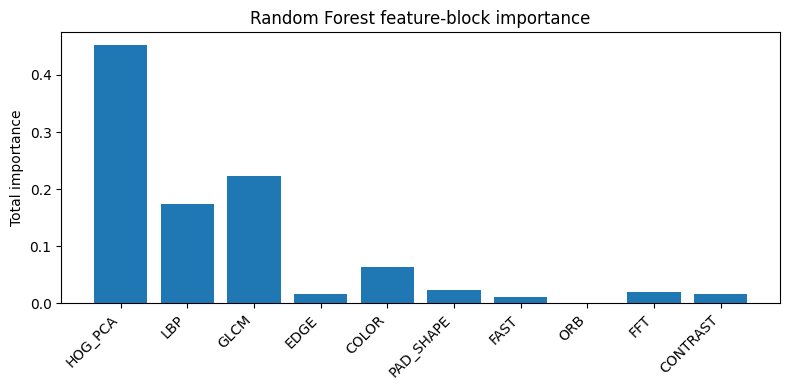

In [23]:
def plot_block_importance(rf_model):
    fi = rf_model.feature_importances_
    assert len(fi) == X_train.shape[1]

    # Build segment indices on the *final* feature vector (after PCA)
    seg = {}
    idx = 0
    seg["HOG_PCA"] = (idx, idx + HOG_PCA_DIM); idx += HOG_PCA_DIM
    seg["LBP"]     = (idx, idx + LBP_LEN);      idx += LBP_LEN
    seg["GLCM"]    = (idx, idx + GLCM_LEN);     idx += GLCM_LEN
    seg["EDGE"]    = (idx, idx + EDGE_LEN);     idx += EDGE_LEN
    seg["COLOR"]   = (idx, idx + COLOR_LEN);    idx += COLOR_LEN
    seg["PAD_SHAPE"] = (idx, idx + PAD_LEN);    idx += PAD_LEN
    seg["FAST"]    = (idx, idx + FAST_LEN);     idx += FAST_LEN
    seg["ORB"]     = (idx, idx + ORB_LEN);      idx += ORB_LEN
    seg["FFT"]     = (idx, idx + FFT_LEN);      idx += FFT_LEN
    seg["CONTRAST"] = (idx, idx + CONTRAST_LEN); idx += CONTRAST_LEN

    assert idx == X_train.shape[1]

    block_names = []
    block_vals  = []
    print("Block importances:")
    for name, (s, e) in seg.items():
        imp = fi[s:e].sum()
        block_names.append(name)
        block_vals.append(imp)
        print(f"{name:10s}: {imp:0.3f}")

    plt.figure(figsize=(8,4))
    plt.bar(block_names, block_vals)
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Total importance")
    plt.title("Random Forest feature-block importance")
    plt.tight_layout()
    plt.show()

plot_block_importance(rf_w)
